In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process.kernels import RationalQuadratic, ExpSineSquared, Matern, WhiteKernel, DotProduct
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.linear_model import BayesianRidge
# from sklearn.model_selection import StratifiedKFold, KFold, StratifiedShuffleSplit, LeaveOneOut
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tqdm import tqdm
from multiprocessing import Pool
import plotly.express as px
import plotly.io as pio
import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.subplots import make_subplots

chestCT = pd.read_csv("Chest_CT_0719.csv", encoding="cp949")
chestCT = chestCT[["Stage_final", "LVI", "volume", "SMI", "Muscle", "FVC", "FVC_measured", "Sex", "Ht", "Date_birth", "Date_CT", "Diagnosis_check", "Hospital_ID", "Time_TIV_death", "Final_Diagnosis_JSK", "PFT_date"]]
chestCT = chestCT.rename(columns={"SMI":"RMI", "volume":"Lung_volume", "Muscle":"Muscle_volume"})

def age(Date, birthDay):
    Date = datetime.strptime(Date, '%Y-%m-%d')
    birthDay = datetime.strptime(birthDay, '%Y-%m-%d')
    age = (Date - birthDay).days
    age = age/365.25
    return age

def calculate_FVC_filter(Date_CT, PFT_date):
    CT = datetime.strptime(Date_CT, '%Y-%m-%d')
    PFT = datetime.strptime(PFT_date, '%Y-%m-%d')
    days_diff = (PFT - CT).days
    if -90 <= days_diff <= 90:
        return 1
    else:
        return np.nan
    
chestCT['Age'] = chestCT.apply(lambda row: age(row["Date_CT"], row["Date_birth"]), axis=1)
chestCT = chestCT[~chestCT["Stage_final"].isin(["0"])] # only omit stage 0
chestCT = chestCT.replace([np.inf, -np.inf], np.nan)
chestCT["Sex"] = chestCT["Sex"].isin(["M"]).astype(int)
chestCT = chestCT[(chestCT["Diagnosis_check"]=='ALS') & (chestCT["Hospital_ID"]!= 56143171) & (chestCT["Time_TIV_death"] < 365*20) & (chestCT["Final_Diagnosis_JSK"] != "Others")]
chestCT = chestCT.drop(["Stage_final", "Date_birth", "Diagnosis_check", "Hospital_ID", "Time_TIV_death", "Final_Diagnosis_JSK"], axis=1)
chestCT = chestCT.dropna(how="any")
chestCT['FVC_filter'] = chestCT.apply(lambda row: calculate_FVC_filter(row["Date_CT"], row["PFT_date"]), axis=1)
chestCT = chestCT.drop(["Date_CT", "PFT_date"], axis=1)
chestCT = chestCT.dropna(how="any")


chestCT = chestCT.sort_values(by='FVC_measured').reset_index(drop=True)

chestCT#.describe()

,LVI,Lung_volume,RMI,Muscle_volume,FVC,FVC_measured,Sex,Ht,Age,FVC_filter,FVC_group
0,840.3,2044.9,429.4,1044.9,11.0,0.30,0,156.0,70.056126,1.0,1
1,1000.4,3098.9,538.7,1668.7,7.0,0.35,1,176.0,33.878166,1.0,1
2,614.3,1533.4,496.9,1240.4,19.0,0.45,0,158.0,71.255305,1.0,1
3,367.4,882.7,523.8,1258.5,24.0,0.45,0,155.0,82.521561,1.0,1
4,699.2,1880.6,429.9,1156.1,14.0,0.49,0,164.0,43.258042,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...
105,1625.8,4566.7,969.2,2722.4,98.0,3.85,1,167.6,64.621492,1.0,5
106,1459.9,4071.5,828.0,2309.3,96.0,3.97,1,167.0,48.960986,1.0,5
107,1777.3,4944.8,870.6,2422.1,109.0,4.24,1,166.8,64.188912,1.0,5
108,1090.3,3077.2,911.5,2572.5,105.0,4.24,1,168.0,60.698152,1.0,5


In [2]:
X = chestCT[["Lung_volume", "Muscle_volume", "Sex", "Age" , "Ht"]]
y = chestCT["FVC_measured"]

scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).ravel()

In [3]:
female = chestCT[chestCT["Sex"]==0]
male = chestCT[chestCT["Sex"]==1]
scaler_F = StandardScaler()
scaler_M = StandardScaler()
female_scaled = scaler_F.fit_transform(female[["Lung_volume", "Muscle_volume", "Sex", "Age" , "Ht"]])
male_scaled = scaler_M.fit_transform(male[["Lung_volume", "Muscle_volume", "Sex", "Age" , "Ht"]])
female_y = female["FVC_measured"]
male_y = male["FVC_measured"]

In [5]:
%matplotlib inline
female = chestCT[chestCT["Sex"]==0]
male = chestCT[chestCT["Sex"]==1]
fig = make_subplots(
    rows=1, cols=3,
    specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}, {'type': 'scatter3d'}]],
    subplot_titles=('Total', 'Female', 'Male')
)
color_min = chestCT['FVC_measured'].min()
color_max = chestCT['FVC_measured'].max()
fig.add_trace(go.Scatter3d(x=chestCT['Lung_volume'], y=chestCT['Muscle_volume'], z=chestCT['Ht'], mode='markers', 
                        marker=dict(size=chestCT['Age'], sizemode='diameter', sizeref=9.*max(chestCT['Age'])/(10.**2), color=chestCT['FVC_measured'], cmin=color_min, cmax=color_max, showscale=True, colorbar=dict(title='FVC_measured', x=1)), 
                        name="total", showlegend=False), 
                        row=1, col=1) 
fig.add_trace(go.Scatter3d(x=female['Lung_volume'], y=female['Muscle_volume'], z=female['Ht'], mode='markers', 
                        marker=dict(size=female['Age'], sizemode='diameter', sizeref=9.*max(chestCT['Age'])/(10.**2), color=female['FVC_measured'], cmin=color_min, cmax=color_max), 
                        name="female", showlegend=False), 
                        row=1, col=2) 
fig.add_trace(go.Scatter3d(x=male['Lung_volume'], y=male['Muscle_volume'], z=male['Ht'], mode='markers', 
                        marker=dict(size=male['Age'], sizemode='diameter', sizeref=9.*max(chestCT['Age'])/(10.**2), color=male['FVC_measured'], cmin=color_min, cmax=color_max), 
                        name="male", showlegend=False), 
                        row=1, col=3) 
zlim_min = chestCT['Ht'].min()-2
zlim_max = chestCT['Ht'].max()+2
ylim_min = chestCT['Muscle_volume'].min()-2
ylim_max = chestCT['Muscle_volume'].max()+2
xlim_min = chestCT['Lung_volume'].min()-2
xlim_max = chestCT['Lung_volume'].max()+2
fig.update_layout(scene1=dict(
                    xaxis_title='Lung_volume',
                    yaxis_title='Muscle_volume',
                    zaxis_title='Ht',
                    zaxis=dict(range=[zlim_min, zlim_max]),
                    yaxis=dict(range=[ylim_min, ylim_max]),
                    xaxis=dict(range=[xlim_min, xlim_max])),
                  scene2=dict(
                    xaxis_title='Lung_volume',
                    yaxis_title='Muscle_volume',
                    zaxis_title='Ht',
                    zaxis=dict(range=[zlim_min, zlim_max]),
                    yaxis=dict(range=[ylim_min, ylim_max]),
                    xaxis=dict(range=[xlim_min, xlim_max])),
                  scene3=dict(
                    xaxis_title='Lung_volume',
                    yaxis_title='Muscle_volume',
                    zaxis_title='Ht',
                    zaxis=dict(range=[zlim_min, zlim_max]),
                    yaxis=dict(range=[ylim_min, ylim_max]),
                    xaxis=dict(range=[xlim_min, xlim_max])),
                    title='Ground Truth. Marker size is Age') 
fig.show()
fig.write_html('GroundTruth_final.html')

/home/kschoi/miniconda3/envs/syj_total/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.

/home/kschoi/miniconda3/envs/syj_total/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 1. Decreasing the bound and calling fit again may find a better value.

/home/kschoi/miniconda3/envs/syj_total/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 1. Decreasing the bound and calling fit again may find a better value.

/home/kschoi/miniconda3/envs/syj_total/

0.6863990551592128
MSE: 0.415, RMSE: 0.6444907213698557, R_square: 0.529, average error range: 0.506933918098378 L
0.00316**2 * RBF(length_scale=1.35) + WhiteKernel(noise_level=0.384) + 0.00316**2 * Matern(length_scale=1, nu=0.5) + 0.0137**2 * DotProduct(sigma_0=2.85) ** 3


/home/kschoi/miniconda3/envs/syj_total/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.

/home/kschoi/miniconda3/envs/syj_total/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.

/home/kschoi/miniconda3/envs/syj_total/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 1. Decreasing the bound and calling fit again may find a better value.



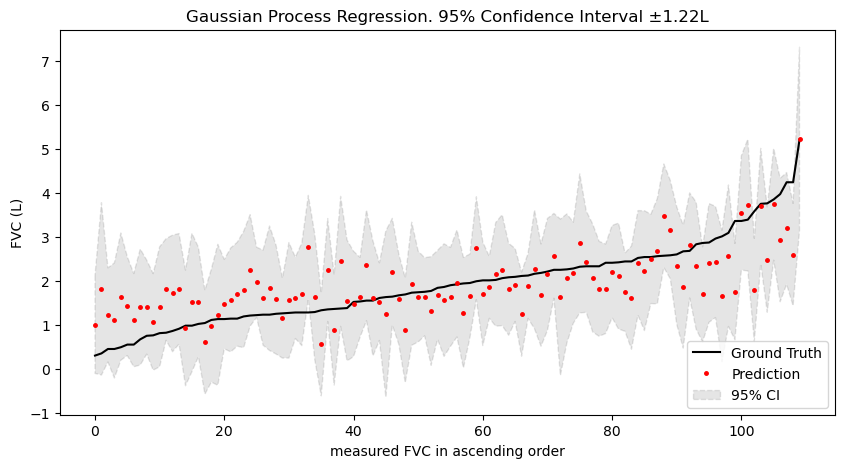

In [79]:
kernel = 5.0 * RBF(length_scale=5, length_scale_bounds=(1, 9)) + WhiteKernel(noise_level=1e-10) + 1 * Matern(length_scale=5, length_scale_bounds=(1, 9), nu=0.5)  + 5.0 * DotProduct(sigma_0=5.0, sigma_0_bounds=(0.1, 10.0)) ** 3
model = GaussianProcessRegressor(kernel=kernel, alpha=1e-03)
loo = LeaveOneOut()
y_pred_all = np.zeros((len(y)))
sigma_pred_all = np.zeros((len(y)))

for i, (train_index, test_index) in enumerate(loo.split(X_scaled)):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y_scaled[train_index], y_scaled[test_index]
    model.fit(X_train, y_train)
    y_pred_all[test_index], sigma_pred_all[test_index] = model.predict(X_test, return_std=True)

y_pred = scaler_y.inverse_transform(y_pred_all.reshape(-1, 1)).ravel()
sigma_pred = sigma_pred_all * scaler_y.scale_
final_mse = mean_squared_error(y, y_pred)
final_mae = mean_absolute_error(y, y_pred)
final_rmse = np.sqrt(final_mse)

In [82]:
chestCT['prediction'] = y_pred

fig = make_subplots(
    rows=1, cols=2,
    specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}]],
    subplot_titles=('Ground Truth', 'Prediction')
)

fig.add_trace(go.Scatter3d(x=chestCT['Lung_volume'], y=chestCT['Muscle_volume'], z=chestCT['FVC_measured'], mode='markers', 
                        marker=dict(size=chestCT['Age'], sizemode='diameter', sizeref=9.*max(chestCT['Age'])/(10.**2), color=chestCT['Ht']), 
                        name="GroundTruth", showlegend=False), 
                        row=1, col=1) 
fig.add_trace(go.Scatter3d(x=chestCT['Lung_volume'], y=chestCT['Muscle_volume'], z=chestCT['prediction'], mode='markers', 
                        # error_z=dict(type='data', visible=True, array=1.96*sigma_pred, thickness=10, width=1, color='rgba(100, 100, 100, 0.7)'),
                        marker=dict(size=chestCT['Age'], sizemode='diameter', sizeref=9.*max(chestCT['Age'])/(10.**2), color=chestCT['Ht'], showscale=True, colorbar=dict(title=dict(text='Height (cm)', font=dict(size=20)), 
                        tickfont=dict(size=20), x=1)), 
                        name="Prediction", showlegend=False), 
                        row=1, col=2) 
# Determine z-axis limits from the first subplot
zlim_min = 0 
zlim_max = chestCT['FVC_measured'].max()+2
axis_settings = dict(
    gridcolor='lightgray',   # Set grid color to light gray
    zerolinecolor='gray',    # Set zero line color to gray
    showbackground=True,     # Show background
    backgroundcolor='white'  # Set background color to white
)
fig.update_layout(scene1=dict(
                    xaxis_title=dict(text='Lung_volume (cm\u00b3)', font=dict(size=20)),
                    yaxis_title=dict(text='Muscle_volume (cm\u00b3)', font=dict(size=20)),
                    zaxis_title=dict(text='FVC_measured (L)', font=dict(size=20)),
                    zaxis=dict(range=[zlim_min, zlim_max]), bgcolor='white'),
                  scene2=dict(
                    xaxis_title=dict(text='Lung_volume (cm\u00b3)', font=dict(size=20)),
                    yaxis_title=dict(text='Muscle_volume (cm\u00b3)', font=dict(size=20)),
                    zaxis_title=dict(text='FVC_measured (L)', font=dict(size=20)),
                    zaxis=dict(range=[zlim_min, zlim_max])),
                    title=f'Gaussian Process Regression. Mean Absolute Error {round(final_mae, 3)} L. Marker size is Age, and Sex is not presented') 

fig.show()
fig.write_html('/media/data/kschoi/GBM_RTA/data_syj/code/ALS_CT/GT_pred_CI.html')